## Hybrid Ice Stream Tidewater

Set up the tidewater side of the model, testing out remeshing to remove zero-thickness areas of ice.

Import firedrake and set initial conditions.

In [1]:
import firedrake
import icepack
import matplotlib.pyplot as plt
import numpy as np

Lx = 100e3
nx = 72

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

/home/sorenthompson/firedrake/src/ngsPETSc/ngsPETSc/eps.py:10: UserWarning: Import Warning: it was not possible to import SLEPc
  warnings.warn("Import Warning: it was not possible to import SLEPc")
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Set up function spaces for the scalars (Q) and vectors (V) for the 2D mesh.

In [2]:
Q = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="R", vdegree=0)
V = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="GL", vdegree=2)

Import a couple constant values from icepack.

In [3]:
from icepack.constants import(
    ice_density as rho_ice,           # ρ_I | 9.21e-19
    water_density as rho_water,       # ρ_W | 1.03e-18
    weertman_sliding_law as weertman, # m   | 3.0
    gravity as g,                     # g   | 9.77e15
)

Set up spatial coordinates and parameterize bed and surface geometry.

$\tau_D$ = driving stress

$$
\tau_D = -\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}
$$

where $g = $ gravity

$h_{in} = $ incoming height

$\frac{\delta s}{\delta x}$ = surface slope

In [4]:
from firedrake import max_value, min_value
from firedrake import conditional, eq, ne, le, ge, lt, gt

x, z = firedrake.SpatialCoordinate(mesh)

b_in, b_out = 100, -200
base_x = b_in - (b_in - b_out) * x/Lx
b = firedrake.interpolate(base_x, Q)

h_in, h_out = 600, 100
h0_x = h_in - (h_in - h_out) * x/Lx
h0 = firedrake.interpolate(h0_x, Q)

s0 = icepack.compute_surface(thickness = h0, bed = b)

# h_in = s_in - b_in
# surface_slope = (s_out - s_in) / Lx # δs_δx
surface_slope = ((b_out + h_out) - (b_in + h_in)) / Lx
tau_D = -rho_ice * g * h_in * surface_slope # driving stress

Check what the profile looks like.

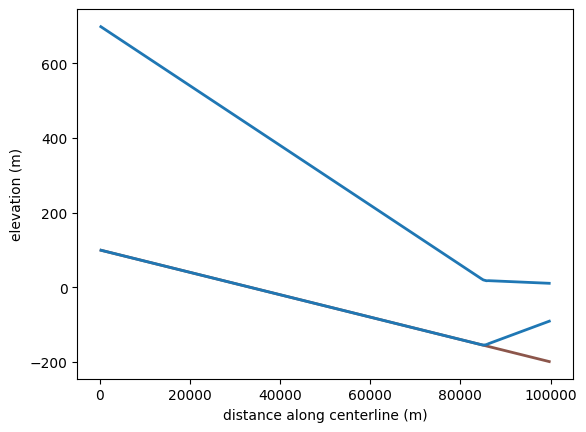

In [5]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb0 = firedrake.interpolate(s0-h0, Q)
firedrake.plot(icepack.depth_average(zb0), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s0), edgecolor="tab:blue", axes = axes);

Estimate intial velocities, increasing exponentially towards the terminus.

$$
u_x = u_{in} + (u_{out} - u_{in}) * \left(\frac{x}{Lx}\right)^2
$$

Just an interpolation between $u_{in}$ and $u_{out}$ using a square.

In [6]:
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x / Lx)**2
u0 = firedrake.interpolate(velocity_x,V) # Vector function space

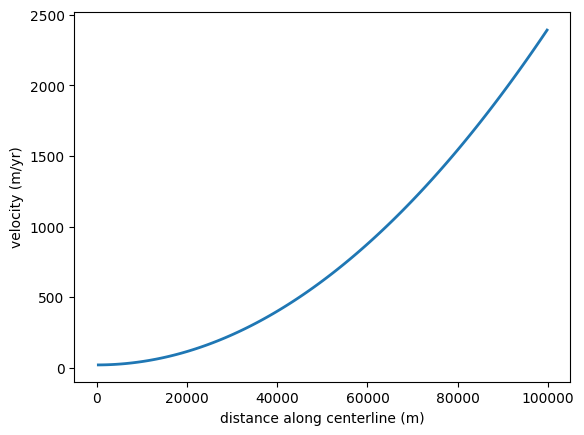

In [7]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0), edgecolor="tab:blue", axes=axes);

Set up icepack values.

water pressure = water density * gravity * amount of ice under the water line (elevation = 0)
ice pressure = ice density * gravity * ice height
phi = ramping function for friction.
- If no water pressure, then phi = 1.
- If ice pressure equals water pressure, then phi = 0.

$C$ = Friction Coeff

$$
C = (0.95 - 0.05 \frac{x}{Lx}) \times \frac{\tau_D}{u_{in}^{1/3}}
$$

where $\tau_D =$ driving stress
and $u_{in} = $ incoming velocity at source

Expanding the driving stress, this is

$$
C = -\left(0.95 - 0.05 \frac{x}{Lx}\right) \times \frac{\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}}{u_{in}^{1/3}}
$$

$C$ decreases slightly along length, then is a ratio of driving stress and incoming velocity

In [8]:
Temperature = firedrake.Constant(255.0) # -18 deg C
A = icepack.rate_factor(Temperature) # flow rate factor

C = firedrake.interpolate((0.95 - 0.05 * x/Lx) * tau_D / u_in ** (1/weertman), Q) # Friction Coeff

$\phi$ = relative pressure at that point

$p_w =$ upward pressure of submerged ice

$p_I = $ downward pressure of unsubmerged ice

In [9]:
p_water = rho_water * g * max_value(0, h0 - s0) # Prevents negative thickness
p_ice = rho_ice * g * h0
phi = 1 - p_water / p_ice # Are there issues if phi = 0?

#### Weertman friction
The law defines the driving stress as

$$
\tau_b = -C|u|^{\frac{1}{m}-1}u
$$

And the energy dissipation is

$$
E(u) = \int \frac{m}{m + 1}C|u|^{\frac{1}{m} + 1}dx.
$$

Weertman is already implemented in Icepack in the `icepack.models.hybrid.bed_friction(velocity = u, friction = C*phi)` function below.

#### Schoof friction approximation

This is implemented in the Synthetic Flowline Ice Stream tutorial as an approximation of the Schoof sliding law. When the velocity is small, energy dissipation acts relative to $|u|^1$, and when it is large, it acts relative to $|u|^{\frac{1}{m}+1}$. The factor $-U_0$ means that there is no flow when there is no energy dissipation.

$$
E(u) = \int \tau_0 \left( \left( U_0^{\frac{1}{m}+1}+|u|^{\frac{1}{m}+1}\right)^{\frac{m}{m+1}} - U_0 \right) dx
$$

In the implementation, $\tau_0$ is

$$
\tau_0 = C \left( U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}}\right)^{\frac{1}{m+1}}
$$

$\phi$ is implemented the same as above, where the amount of water displaced is the height of ice submerged $h_{sub} = h-s$

$$
\phi = 1 - \frac{\rho_{water}}{\rho_{ice}} \frac{(h_{sub})}{h_{supra}}
$$

Finally, friction is calculated as

$$
\tau_0 \times \phi \times \left(\left(U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}} \right)^{\frac{1}{m+1}} - U_0 \right)
$$


In [10]:
import icepack.models.hybrid

## Weertman friction
def weertman_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice
    
    return icepack.models.hybrid.bed_friction(
        velocity = u,
        friction = C * phi,
    )

from firedrake import sqrt, inner

def schoof_approx_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    U_0 = firedrake.Constant(50)
    U = sqrt(inner(u,u)) # Supposed to be u0, does this work?
    tau_0 = firedrake.interpolate(
        C*( U_0**(1/weertman+1) + U**(1/weertman+1) )**(1/(weertman+1)), Q
    ) # Including Q is an issue here, can we reference the current Q through one of the functions?
    
    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice

    U = sqrt(inner(u, u))
    return tau_0 * phi * (
        (U_0**(1/weertman+1) + U**(1/weertman+1))**(weertman/(weertman+1))-U_0
    )

Set up hybrid model solver with custom friction function and initialize the velocity field.

In [11]:
# model = icepack.models.HybridModel(friction = schoof_approx_friction)
model = icepack.models.HybridModel(friction = weertman_friction)
opts = {
    "dirichlet_ids": [1],
    #"diagnostic_solver_type": "petsc",
    #"diagnostic_solver_parameters": {"snes_type": "newtontr"},
}

solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity = u0,
    thickness = h0,
    surface = s0,
    fluidity = A,
    friction = C,
)

Plot new initial velocities.

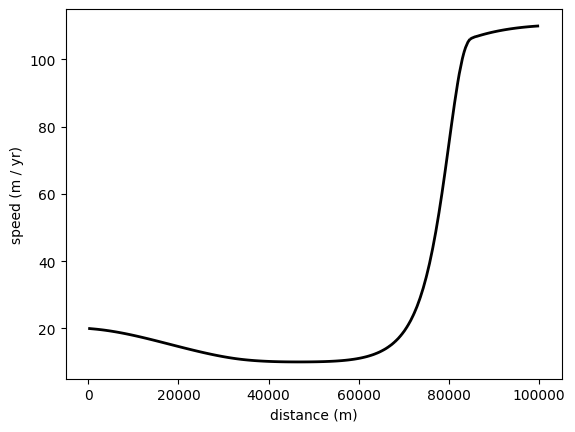

In [12]:
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes);

### Run the actual model

In [13]:
h_min = 10 # base height past the terminus/"empty" portion of the glacier
h_calving = 50 # the height the glacier calves at.
cal_step = h_calving - h_min

In [14]:
from scipy.interpolate import interp1d
import xarray

def shrink_function(func_src, nx, Lx_src, Lx_dest, funcspace_dest):
    # Pull out list of values from func_src
    f_data_src = func_src.dat.data
    
    # Initialize linspace lists with lengths Lx_src and Lx_dest
    f_data_len = len(f_data_src)
    f_ls_src = np.linspace(0, Lx_src, f_data_len, endpoint=True)
    f_ls_dest= np.linspace(0, Lx_dest, f_data_len, endpoint=True)
    
    # Interpolate f_data_src from f_ls_src to f_ls_dest
    f_interpolator = interp1d(f_ls_src, f_data_src, kind='linear', fill_value='extrapolate')
    f_data_dest = f_interpolator(f_ls_dest)
    
    # Convert f_data_dest into a firedrake function on destination function space funcspace_dest
    temp_dest = xarray.DataArray(f_data_dest, [f_ls_dest], 'x')
    func_dest = icepack.interpolate(temp_dest, funcspace_dest)

    func_dest.dat.data[-1] = temp_dest[-1]
    
    return func_dest

In [15]:
def shrink_model(nx, Lx_src, Lx_dest, h_src, u_src, a_src, h0_src, b_src, s_src, C_src):
    # Initialize mesh and mesh spaces
    mesh1d_dest = firedrake.IntervalMesh(nx, Lx_dest)
    mesh_dest = firedrake.ExtrudedMesh(mesh1d_dest, layers=1)
    Q_dest = firedrake.FunctionSpace(mesh_dest, "CG", 2, vfamily="R", vdegree=0)
    V_dest = firedrake.FunctionSpace(mesh_dest, "CG", 2, vfamily="GL", vdegree=0)
    
    # Remesh all functions
    h_dest =  shrink_function(h_src,  nx, Lx_src, Lx_dest, Q_dest)
    u_dest =  shrink_function(u_src,  nx, Lx_src, Lx_dest, V_dest)
    a_dest =  shrink_function(a_src,  nx, Lx_src, Lx_dest, Q_dest)
    h0_dest = shrink_function(h0_src, nx, Lx_src, Lx_dest, Q_dest)
    b_dest =  shrink_function(b_src,  nx, Lx_src, Lx_dest, Q_dest)
    s_dest =  shrink_function(s_src,  nx, Lx_src, Lx_dest, Q_dest)
    C_dest =  shrink_function(C_src,  nx, Lx_src, Lx_dest, Q_dest)
    
    return Q_dest, V_dest, h_dest, u_dest, a_dest, h0_dest, b_dest, s_dest, C_dest

In [16]:
def find_endpoint_haf(src_lx, src_nx, src_h, src_s, src_Q):
    zb_end = firedrake.interpolate(src_s-src_h, src_Q)
    # zb_end = src_b
    float_h = firedrake.interpolate(-rho_water/rho_ice*zb_end, src_Q)
    h_above_f = firedrake.interpolate(src_h - float_h, src_Q)

    # fig, axes = plt.subplots()
    # axes.set_xlabel("distance (m)")
    # axes.set_ylabel("HAF (m)")
    # firedrake.plot(icepack.depth_average(h_above_f), axes=axes);

    haf_dat = h_above_f.dat.data
    x_dat = np.linspace(0, src_lx, len(src_h.dat.data), endpoint=True)
    haf_interpolator = interp1d(haf_dat, x_dat, fill_value='extrapolate')
    L_new = haf_interpolator(1)
    return L_new
    
    # zb = firedrake.interpolate(model_s-model_h, model_Q)

Define accumulation function

In [17]:
from firedrake import ln, exp
def mass_balance(mb_h, mb_Q):
    mb_gradient = 0.02
    mb_max = 5
    ELA = 200
    mb_k = 0.005
    z_threshold = mb_max/mb_gradient + ELA
    mb_sea = -8
    
    mb_a = firedrake.interpolate(mb_gradient * (h0 - 1/(2*mb_k) * ln(1 + exp(2*mb_k*(h0 - z_threshold)))),Q)
    return mb_a

NameError: name 'a' is not defined

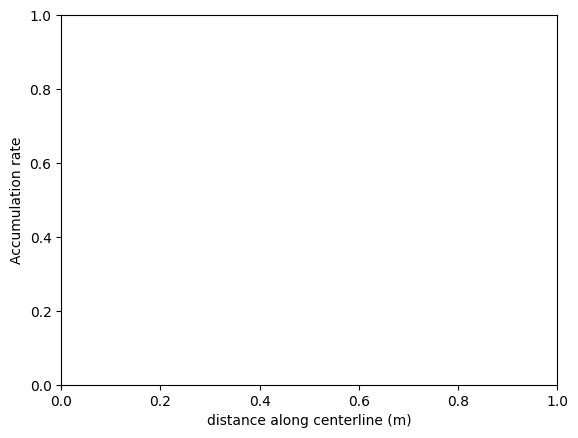

In [18]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("Accumulation rate")
firedrake.plot(icepack.depth_average(a), axes=axes);

In [19]:
import tqdm

num_years = 100
timesteps_per_year = 2
snapshot_location = [0, 50, 100, 150, 200]
snapshots = []

dt = 1.0/timesteps_per_year
num_timesteps = num_years * timesteps_per_year

# a = firedrake.interpolate(4.7 - 4.7 * x / Lx, Q) # use elevation instead of position, linear increase with elevation to maximum
a = mass_balance(h0, Q)
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)
s = icepack.compute_surface(thickness=h, bed=b)

# Copy over values to initialize versions that can be modified in the model loop

model_nx = nx
model_Lx = Lx

# Use shrink_model function to make copies of functions and function spaces
model_Q, model_V, model_h, model_u, model_a, model_h0, model_b, model_s, model_C = shrink_model(
    nx, Lx, Lx, h, u, a, h0, b, s, C)

# Initialize a new solver
loop_model = icepack.models.HybridModel(friction = weertman_friction)
model_solver = icepack.solvers.FlowSolver(loop_model, **opts)

# Run the model loop
for step in tqdm.trange(num_timesteps):
    
    model_h = model_solver.prognostic_solve(
        dt,
        thickness = model_h,
        velocity = model_u,
        accumulation = model_a,
        thickness_inflow = model_h0,
    )

    model_s = icepack.compute_surface(thickness = model_h, bed = model_b)
    model_a = mass_balance(model_a, model_Q)

    temp_Lx= find_endpoint_haf(model_Lx, nx, model_h, model_s, model_Q)
    model_Q, model_V, model_h, model_u, model_a, model_h0, model_b, model_s, model_C = shrink_model(
        model_nx, model_Lx, temp_Lx, model_h, model_u, model_a, model_h0, model_b, model_s, model_C)
    model_Lx = temp_Lx
    
    loop_model = icepack.models.HybridModel(friction = weertman_friction)
    model_solver = icepack.solvers.FlowSolver(loop_model, **opts)
    
    model_u = model_solver.diagnostic_solve(
        velocity = model_u,
        thickness = model_h,
        surface = model_s,
        fluidity = A,
        friction = model_C,
    )
    if (step in snapshot_location):
        print("saving snapshot")
        snapshots.append(model_s.copy(deepcopy=True))
        # It would be nice to append a 0 onto the end of each snapshot for visualization

print("Done!")

  0%|▎                                                 | 1/200 [00:00<02:08,  1.55it/s]

saving snapshot


 26%|████████████▍                                    | 51/200 [00:20<00:54,  2.74it/s]

saving snapshot


 50%|████████████████████████▏                       | 101/200 [00:37<00:27,  3.58it/s]

saving snapshot


 76%|████████████████████████████████████▏           | 151/200 [00:51<00:11,  4.09it/s]

saving snapshot


100%|████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.22it/s]

Done!


Plot the profile

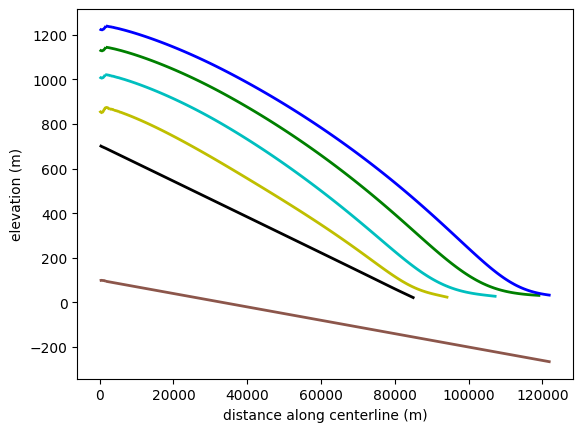

In [21]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

# Plot the previous timestep profile
# firedrake.plot(icepack.depth_average(prev_b), edgecolor="tab:green", axes=axes)
# prev_zb = firedrake.interpolate(prev_s-prev_h, prev_Q)
# firedrake.plot(icepack.depth_average(prev_zb), edgecolor="tab:green", axes = axes)
# firedrake.plot(icepack.depth_average(prev_s), edgecolor="tab:green", axes = axes);

# Plot the current timestep profile)
firedrake.plot(icepack.depth_average(model_b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(model_s-model_h, model_Q)
# firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(snapshots[0]), edgecolor = '0', axes=axes)
firedrake.plot(icepack.depth_average(snapshots[1]), edgecolor = 'y', axes=axes)
firedrake.plot(icepack.depth_average(snapshots[2]), edgecolor = 'c', axes=axes)
firedrake.plot(icepack.depth_average(snapshots[3]), edgecolor = 'g', axes=axes)
firedrake.plot(icepack.depth_average(model_s), edgecolor = 'b', axes=axes);

# fig2, axes2 = plt.subplots()
# axes2.set_xlabel("distance along centerline (m)")
# axes2.set_ylabel("velocity (m/yr)")
# firedrake.plot(icepack.depth_average(prev_u), axes=axes2);

# print(prev_h.dat.data)
# print(mid_h_1.dat.data)
# print(mid_h_2.dat.data)
# print(model_h.dat.data)

# print(prev_u.dat.data)
# print(model_u.dat.data)

### Old Functions

In [ ]:
def find_endpoint(src_lx, src_nx, src_h, h_min):
    # print(src_h.dat.data)
    h_dat = src_h.dat.data
    x_dat = np.linspace(0, src_lx, len(src_h.dat.data), endpoint=True)
    endpoint_interpolator = interp1d(h_dat, x_dat, fill_value='extrapolate')
    L_new = endpoint_interpolator(h_min)
    return L_new

def find_endpoint_1(src_lx, src_nx, src_h, h_min):
    for i in range(0, len(src_h.dat.data)):
        if src_h.dat.data[i] <= h_min:
            return src_lx*i/len(src_h.dat.data)
    return src_lx

def find_endpoint_2(src_lx, src_nx, src_h, h_min):
    for i in range(0, len(src_h.dat.data)):
        if src_h.dat.data[i] <= h_min:
            delta_h = (src_h.dat.data[i-1] - src_h.dat.data[i])
            delta_l = src_lx/int(len(src_h.dat.data))
            small_l = (h_min-src_h.dat.data[i]) * delta_l / delta_h
            return src_lx * (i-1) / len(src_h.dat.data) + small_l
    return src_lx

In [ ]:
import tqdm

num_years = 100
timesteps_per_year = 2

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q) # Ramping accumulation along length
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)

height_min1 = np.zeros(num_timesteps) * np.nan
height_min2 = np.zeros(num_timesteps) * np.nan
endpoints = np.zeros(num_timesteps) * np.nan

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness = h,
        velocity = u,
        accumulation = a,
        thickness_inflow = h0,
    )
    
    height_min1[step] = h.dat.data_ro.min()

    h = icepack.interpolate(conditional(lt(h,h_calving),h_min,h),Q) # Calving to minimum stable value (use UFL for functions)

    # Remeshing Steps:
        # Find new endpoint
    endpoint = find_endpoint(Lx, nx, h, h_min)
        # Shrink model
    # Q_s, V_s, h1_s, u1_s, a_s, h0_s, b_s, s1_s, C_s = shrink_model(nx, Lx, endpoint, h1, u1, a, h0, b, s1, C)
        # Recalculate surface
        # Initialize new solver
        # Re-assign functions, length, solver

    s = icepack.compute_surface(thickness=h, bed=b)

    u = solver.diagnostic_solve(
        velocity = u,
        thickness = h,
        surface = s,
        fluidity = A,
        friction = C,
    )

    endpoints[step] = endpoint
    height_min2[step] = h.dat.data_ro.min()

### Function Tests

In [ ]:
# Test shrink functions

# Initialze some smaller test meshes
mesh1d_test = firedrake.IntervalMesh(nx, 90000)
mesh_test = firedrake.ExtrudedMesh(mesh1d_test, layers=1)
Q_test = firedrake.FunctionSpace(mesh_test, "CG", 2, vfamily="R", vdegree=0)
V_test = firedrake.FunctionSpace(mesh_test, "CG", 2, vfamily="GL", vdegree=0)

# Shrink the meshes
h0_test = shrink_function(h0, nx, Lx, 90000, Q_test)
u0_test = shrink_function(u0, nx, Lx, 90000, V_test)
s0_test = shrink_function(s0, nx, Lx, 90000, Q_test)

# Chart output
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")

u0_test_scaled = firedrake.interpolate(u0_test/5,V_test);
firedrake.plot(icepack.depth_average(u0_test_scaled), axes=axes);
firedrake.plot(icepack.depth_average(s0_test), axes=axes);

zb0_test = firedrake.interpolate(s0_test-h0_test, Q_test)
firedrake.plot(icepack.depth_average(zb0_test), axes=axes);

In [ ]:
# Model Remesh Test
dt = 0.25

# Set accumulation rate and copy initial height and velocities
a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q)
h1 = h0.copy(deepcopy = True)
u1 = u0.copy(deepcopy = True)

# Solve the first two timesteps WITHOUT remeshing
h1 = solver.prognostic_solve(dt, thickness=h1, velocity=u1, accumulation=a, thickness_inflow=h0)
s1 = icepack.compute_surface(thickness=h1, bed=b)
u1 = solver.diagnostic_solve(velocity=u1, thickness=h1, surface=s1, fluidity=A, friction=C)

h2 = solver.prognostic_solve(dt, thickness=h1, velocity=u1, accumulation=a, thickness_inflow=h0)
s2 = icepack.compute_surface(thickness=h2, bed=b)
u2 = solver.diagnostic_solve(velocity=u1, thickness=h2, surface=s2, fluidity=A, friction=C)

# Remesh (using the same initial length, so really just copying all the functions to a new mesh)
Q_s, V_s, h1_s, u1_s, a_s, h0_s, b_s, s1_s, C_s = shrink_model(nx, Lx, 100000, h1, u1, a, h0, b, s1, C)

# Initialize a new model and solver (is this necessary with every remesh?)
# model2 = icepack.models.HybridModel(friction = schoof_approx_friction)
model2 = icepack.models.HybridModel(friction = weertman_friction)
solver2 = icepack.solvers.FlowSolver(model2, **opts)

# Solve the second timestep with the remeshed functions
h2_s = solver2.prognostic_solve(dt, thickness=h1_s, velocity=u1_s, accumulation=a_s, thickness_inflow=h0_s)
s2_s = icepack.compute_surface(thickness = h2_s, bed = b_s)
u2_s = solver2.diagnostic_solve(velocity=u1_s, thickness=h2_s, surface=s2_s, fluidity=A, friction=C_s) # THIS LINE IS THE ISSUE

# Plot profile.
# Black = initial conditions, first timestep
# Blue = second timestep without shortening
# Green = second timestep with shortening
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("height (m)")

zb0 = firedrake.interpolate(s0-h0, Q)
zb1 = firedrake.interpolate(s1-h1, Q)
zb2 = firedrake.interpolate(s2-h2, Q)
zb2_s = firedrake.interpolate(s2_s-h2_s, Q_s)

firedrake.plot(icepack.depth_average(b_s), axes = axes);
firedrake.plot(icepack.depth_average(zb0), axes = axes);
firedrake.plot(icepack.depth_average(zb1), axes=axes);
firedrake.plot(icepack.depth_average(zb2), edgecolor = "tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(zb2_s), edgecolor = "tab:green", axes=axes);
firedrake.plot(icepack.depth_average(s0), axes = axes);
firedrake.plot(icepack.depth_average(s1), axes=axes);
firedrake.plot(icepack.depth_average(s2), edgecolor = "tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(s2_s), edgecolor = "tab:green", axes=axes);

# Plot Velocity.
# Black = initial conditions, first timestep
# Blue = first step (before shortening)
fig2, axes2 = plt.subplots()
axes2.set_xlabel("distance (m)")
axes2.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes2);
firedrake.plot(icepack.depth_average(u1), edgecolor = "tab:blue", axes=axes2);
firedrake.plot(icepack.depth_average(u1_s), edgecolor = "tab:green", axes=axes2);
firedrake.plot(icepack.depth_average(u2), edgecolor = "tab:blue", axes=axes2);
firedrake.plot(icepack.depth_average(u2_s), edgecolor = "tab:green", axes=axes2);

# firedrake.plot(icepack.depth_average(u1_s/10), axes=axes);

In [ ]:
# Endpoint tests
test_val_x1 = find_endpoint_1(Lx, nx, b, 50)
test_val_x2 = find_endpoint_2(Lx, nx, b, 50)
test_val_x3 = find_endpoint(Lx, nx, b, 50)
print(test_val_x1)
print(test_val_x2)
print(test_val_x3)

test_val_y1 = b.at(test_val_x1,0)
test_val_y2 = b.at(test_val_x2,0)
test_val_y3 = b.at(test_val_x3,0)
print(test_val_y1)
print(test_val_y2)
print(test_val_y3)

test_val_x_haf = find_endpoint_haf(Lx, nx, h0, s0, Q)
print(test_val_x_haf)